# Standard benchmark notebook for Deconvolution

Execution time on Martin's laptop (CPU)

In [1]:
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib notebook 
# uncomment the above to use the interactive plots.
import os
from copy import deepcopy
from matplotlib import colors

from starred.deconvolution.deconvolution import Deconv, setup_model
from starred.deconvolution.loss import Loss, Prior
from starred.deconvolution.parameters import ParametersDeconv
from starred.procedures.deconvolution_routines import multi_steps_deconvolution
from starred.plots.plot_function import plot_deconvolution, view_deconv_model
from starred.utils.noise_utils import propagate_noise
from starred.optim.optimization import Optimizer
from jax import jit, grad

from astropy.io import fits
import pickle as pkl 

In [2]:
# Parameters
t_exp = 30.
subsampling_factor = 2 # the upsampling we used to represent the PSF
# since the noise is normalized,
# you will typically want your lambda_scale (regularization strength) relatively close to 1.
lambda_scales = 5.
# lambda_hf should be set to a very high number if you don't expect point sources in the extended channel. 
lambda_hf = 5.
data_path = 'input/test_background_holes'
convolution_method = 'scipy'

benchmark=True

In [3]:
# Retrieving data
### if you want a single epoch, just prepare a data directory with a single file
### instead of 2 like we have here.
file_paths = sorted(glob.glob(os.path.join(data_path, 'lens*.fits')))
data = np.array([fits.open(f)[0].data for f in file_paths]) 

im_size = np.shape(data)[1]
epochs = np.shape(data)[0]
print(data.shape)

# Noise map
file_paths = sorted(glob.glob(os.path.join(data_path, 'sigma*.fits')))
sigma_2 = np.array([fits.open(f)[0].data for f in file_paths]) ** 2


# Noise map
# sigma_2 = np.zeros((epochs, im_size, im_size))
# sigma_sky_2 = np.array([np.std(data[i,int(0.9*im_size):,int(0.9*im_size):]) for i in range(epochs)]) ** 2
# for i in range(epochs):
    # sigma_2[i,:,:] = sigma_sky_2[i] + data[i,:,:].clip(min=0)

# print(sigma_2.shape)

print(np.mean(sigma_2))

(2, 64, 64)
21.490456432130053


In [4]:
# Retrieving the PSF (must have one per epoch)
file_paths = sorted(glob.glob(os.path.join(data_path, 'narrow_PSF*.fits')))
s = np.array([fits.open(f)[0].data for f in file_paths])

im_size_up = s.shape[1]
print(s.shape)

(2, 128, 128)


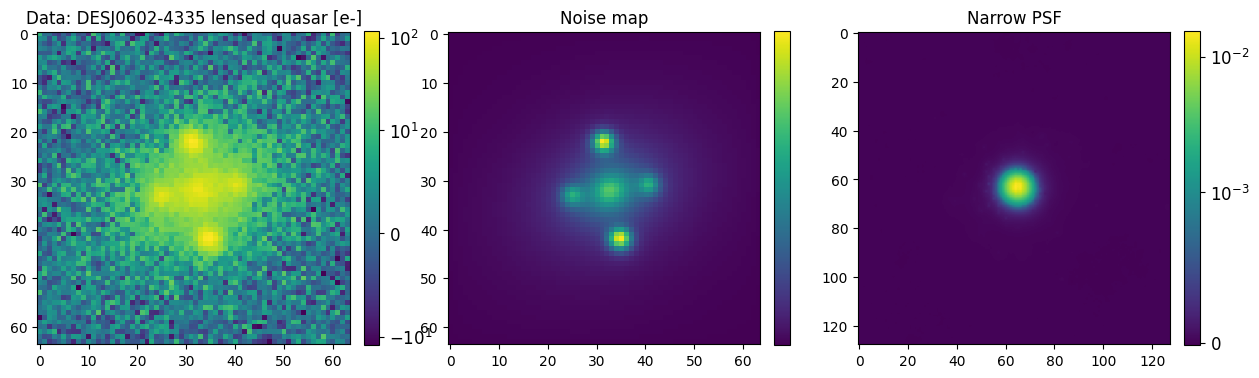

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(15,6))
fraction = 0.046
pad = 0.04
ep = 0

plt.rc('font', size=12)           
axs[0].set_title('Data: DESJ0602-4335 lensed quasar [e-]', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[1].set_title('Noise map', fontsize=12)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[2].set_title('Narrow PSF', fontsize=12)
axs[2].tick_params(axis='both', which='major', labelsize=10)

fig.colorbar(axs[0].imshow(data[ep,...], norm=colors.SymLogNorm(linthresh=10)), ax=axs[0], fraction=fraction, pad=pad)
fig.colorbar(axs[1].imshow(sigma_2[ep,...], norm=colors.SymLogNorm(linthresh=10)), ax=axs[1], fraction=fraction, pad=pad)
fig.colorbar(axs[2].imshow(s[ep,...], norm=colors.SymLogNorm(linthresh=1e-3)), ax=axs[2], fraction=fraction, pad=pad)
plt.show()

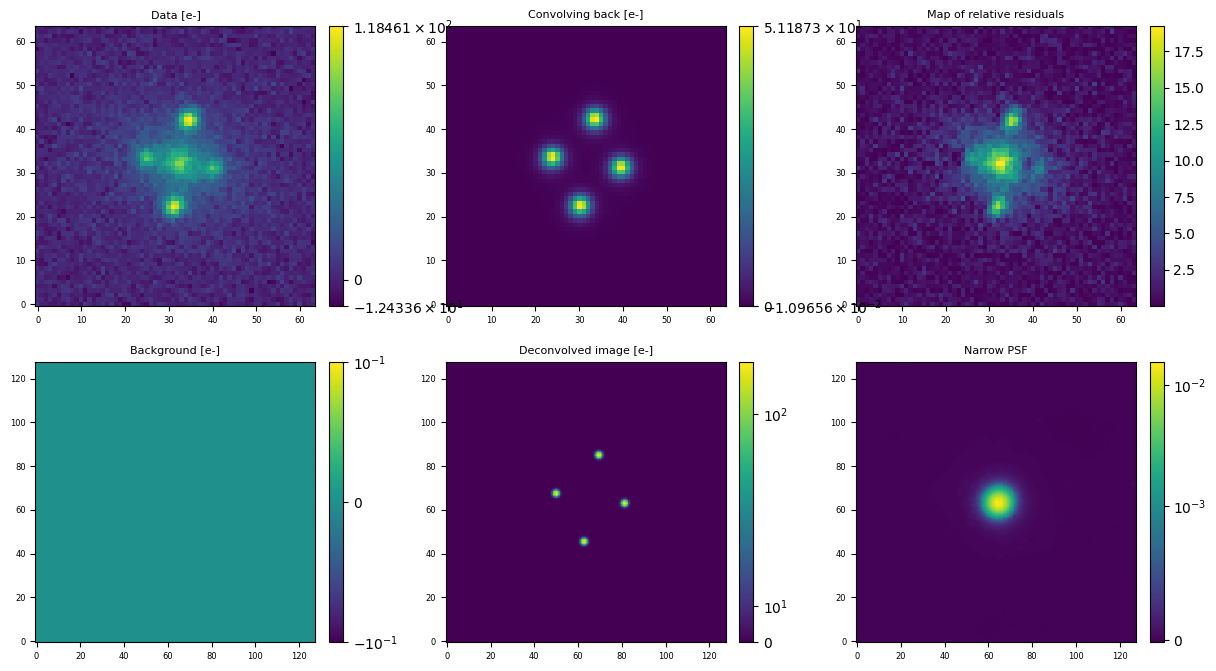

In [6]:
# Parameter initialization
with open(os.path.join(data_path, 'info_exp0.pkl'), 'rb') as f:
    source_amp, amps, mag, mag_lensed, lcs, SNR, shift_vecx, shift_vecy, ps_ra, ps_dec = pkl.load(f)

pixel_size = 0.21 
initial_c_x = ps_ra/pixel_size -0.5
initial_c_y = ps_dec/pixel_size
M = len(initial_c_x)
initial_a = 1000*np.array([data[i,:,:].max() for i in range(epochs) for j in range(M)]) 
# provide a normalization for the image, makes things numerically more tractable:
scale = data.max()
initial_a /= scale
# we will also provide the Deconvolution class with this scale at the end of this cell.

# Getting the model and kwargs:
model, kwargs_init, kwargs_up, kwargs_down, kwargs_fixed = setup_model(data, sigma_2, s, initial_c_x, initial_c_y, subsampling_factor, 
                                                                       initial_a = initial_a, astrometric_bound = 5, dithering_bound = 10,
                                                                       convolution_method = 'fft')

parameters = ParametersDeconv(kwargs_init, 
                              kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)


#define wide prior for the point source position
# prior = Prior(prior_analytic=[['c_x',initial_c_x,2.], ['c_y',initial_c_y, 2.]], prior_background=None)

#view intitial conditions 
fig_preview = plot_deconvolution(model, data, sigma_2, s, kwargs_init, epoch = 0, units='e-')
plt.show()

0.0022702091
0.0050611384
0.008229036
0.007655656
0.0048335707
0.0025173165
0.0011834658
0.0005510231


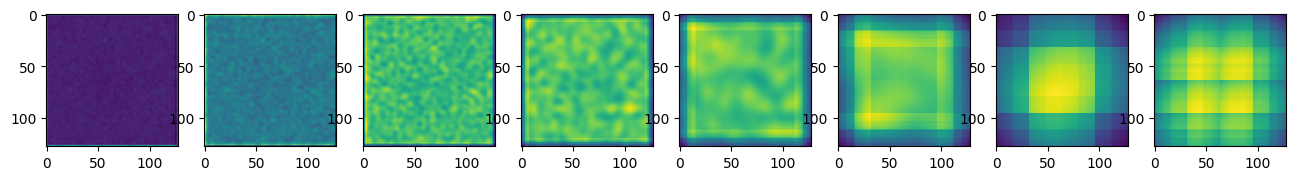

In [7]:
# compute noise level in starlet space
W = propagate_noise(model, np.sqrt(sigma_2), kwargs_init, wavelet_type_list=['starlet'], 
                    method='MC', num_samples=200, seed=1, likelihood_type='chi2', 
                    verbose=False, upsampling_factor=subsampling_factor)[0]

#This is a representation of your noise level (background + Poisson) in the different starlet scales
gix, axs = plt.subplots(1, len(W), figsize=(16, 4))
for i, l in enumerate(W):
    axs[i].imshow(l)
    print(np.mean(l))
plt.show()


In [8]:
# same as before, first raise the background a little.

# fix the point sources to our initial guess
kwargs_fixed['kwargs_analytic']['c_x'] = kwargs_init['kwargs_analytic']['c_x'] 
kwargs_fixed['kwargs_analytic']['c_y'] = kwargs_init['kwargs_analytic']['c_y']
# kwargs_fixed['kwargs_analytic']['a'] = kwargs_init['kwargs_analytic']['a']


# let's optimize!
parameters = ParametersDeconv(kwargs_init=kwargs_init, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

args = parameters.kwargs2args(kwargs_init)

# raise the background 
loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=lambda_scales, 
            regularization_strength_hf=lambda_hf, 
            regularization_strength_positivity=100,# here we add a penalty if negative background,
            regularize_pts_source=False, 
            W=W)                                    


if benchmark: 
    @jit
    def jitted_loss(args):
        return loss.loss(args)

    @jit
    def gradient(args):
        return grad(loss.loss)(args)

    LogL = jitted_loss(args)

    %timeit loss.loss(args)
    %timeit jitted_loss(args)
    %timeit gradient(args)

    if 1: 
        print('Convolution runtime (jitted):')
        @jit
        def convolve_jitted(kwargs): 
            return loss._deconv.model(kwargs)
        
        @jit 
        def regul_jitted(kwargs):
            return loss._log_regul(kwargs)
        
        %timeit convolve_jitted(kwargs_init)

        print('Regul runtime (jitted):')
        %timeit regul_jitted(kwargs_init)

    #Main branch loss execution time :
    #non-jitted : 79ms 
    #jitted : 29.2 ms (from which 3ms from convolution / 27ms from regularisation)
    #grad : 63.8 ms

    #masking_pts branch: 
    #non-jitted : 118ms 
    #jitted : 52.6 ms
    #grad : 119 ms

    #main branch GPU on sherlock: 
    # non-jitted loss : 8.64 ms ± 21.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
    # jitted loss : 658 µs ± 14 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
    # jitted grad: 709 µs ± 49.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
    # Convolution runtime (jitted):
    # 525 µs ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
    # Regul runtime (jitted):
    # 297 µs ± 15.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


AttributeError: 'Loss' object has no attribute 'n_scale'

In [ ]:
optim = Optimizer(loss, parameters, method='adabelief')
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(restart_from_init=True, 
                                                                init_learning_rate=5e-2,
                                                                schedule_learning_rate=False,
                                                                max_iterations=500)

kwargs_partial = deepcopy(parameters.best_fit_values(as_kwargs=True))
print('final loss:', optim.loss_history[-1])

print(runtime)

#main branch runtime : 
#38.1 s for 500 iterations ~15it/s on martin's new laptop

#masking_pts branch: 
#123s / 1000 iterations ~8it/s

#main branch GPU on sherlock: 
#7.25s / 500 iterations ~70it/s 

optax.adabelief: 100%|██████████| 500/500 [00:46<00:00, 10.66it/s]


final loss: 2162.0793
47.047561168670654


final loss: 2162.0793
{'kwargs_analytic': {'a': Array([15.2467985, 14.752865 ,  8.917161 ,  8.678287 , 14.028539 ,
       14.230543 ,  8.172402 ,  7.3520756], dtype=float32), 'c_x': Array([ 2.6917918 , -0.68921554,  8.590228  , -7.0885506 ], dtype=float32), 'c_y': Array([10.510139  , -9.270156  , -0.52056366,  1.7355891 ], dtype=float32), 'dx': Array([1.1012921, 2.319408 ], dtype=float32), 'dy': Array([-0.26757398, -1.5927942 ], dtype=float32), 'alpha': Array([0., 0.], dtype=float32)}, 'kwargs_background': {'mean': Array([0.14480418, 0.1938894 ], dtype=float32), 'h': Array([0.34409398, 0.22852203, 0.33779272, ..., 0.22227561, 0.25316852,
       0.258018  ], dtype=float32)}, 'kwargs_sersic': {'amp': Array([], dtype=float32), 'R_sersic': Array([], dtype=float32), 'n_sersic': Array([], dtype=float32), 'center_x': Array([], dtype=float32), 'center_y': Array([], dtype=float32), 'e1': Array([], dtype=float32), 'e2': Array([], dtype=float32)}}


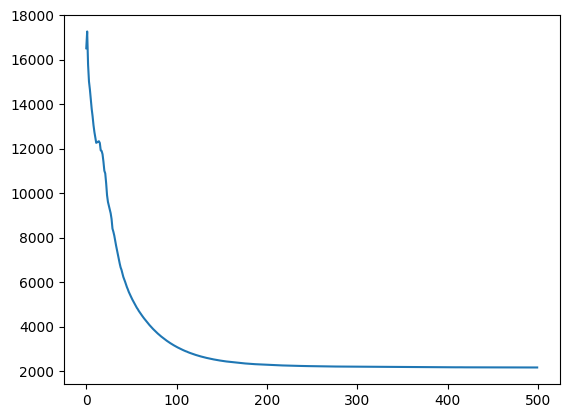

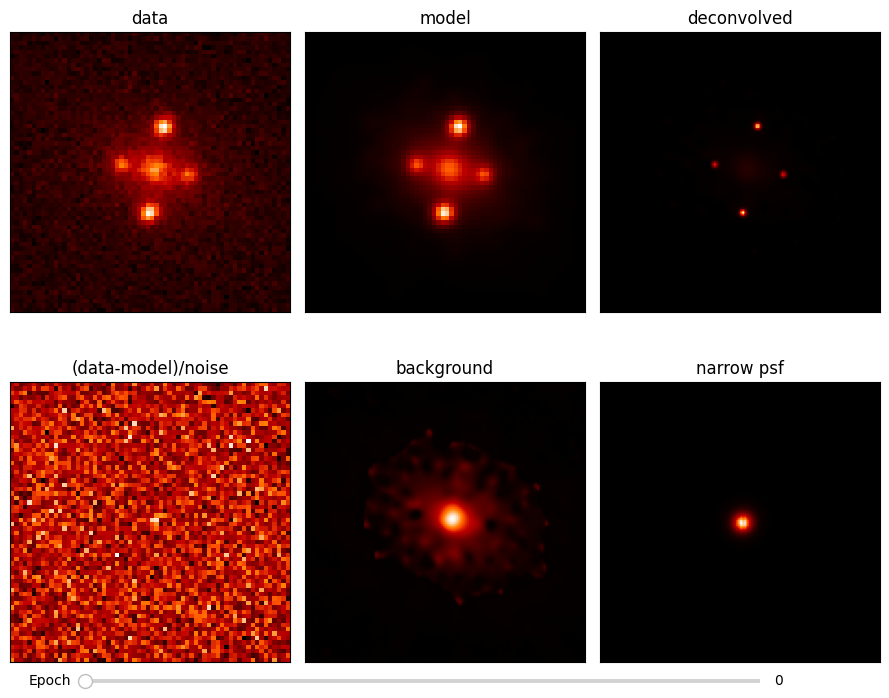

In [ ]:
plt.figure()
plt.plot(optim.loss_history)
print('final loss:', optim.loss_history[-1])

# Printing final results
print(kwargs_partial)
# we can use our crude inspection plot function:
view_deconv_model(model, kwargs_partial, data, sigma_2)

Overall Reduced Chi2 :  0.97477835


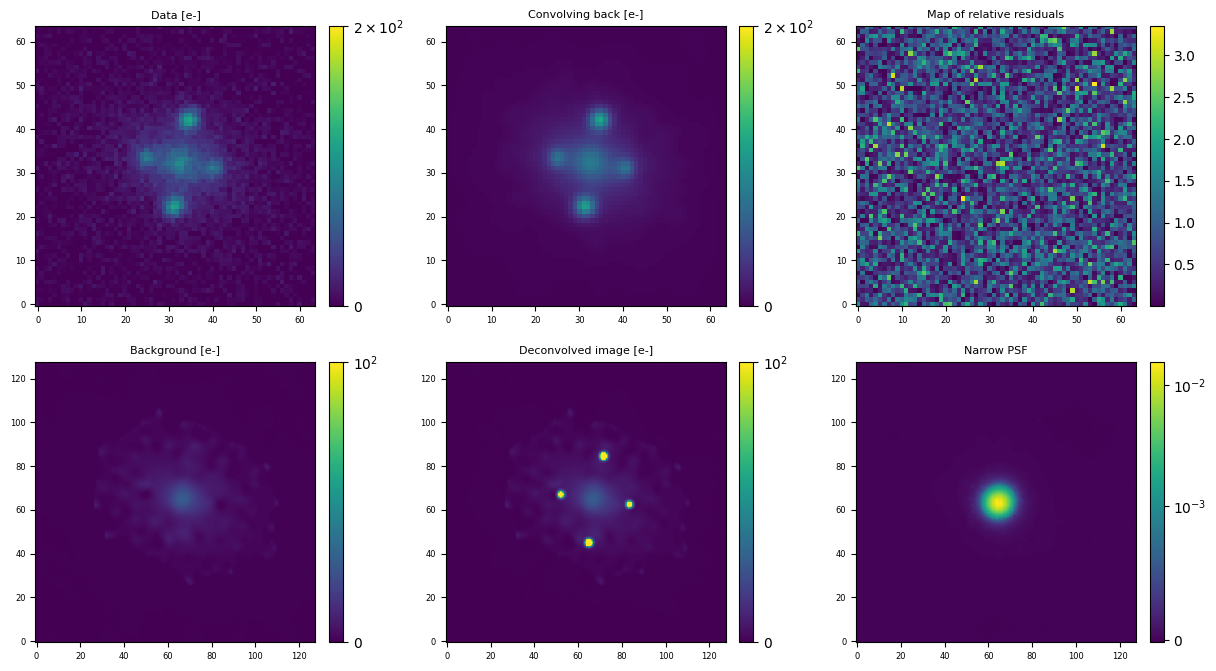

In [ ]:
cut_dict = {
            'linthresh':[200,200,None,100,100,1e-3],
            'vmin':[0,0, None, 0, 0, None],
            'vmax':[200, 200, None,100,100, None],
        }
fig2 = plot_deconvolution(model, data, sigma_2, s, kwargs_partial, epoch = 0, units='e-', cut_dict=cut_dict)

print('Overall Reduced Chi2 : ', -2 * loss._log_likelihood_chi2(kwargs_partial) / (im_size ** 2))

In [ ]:

# unfix the point sources to our initial guess
kwargs_fixed['kwargs_analytic'] = {}
# kwargs_fixed['kwargs_analytic']['a'] = kwargs_init['kwargs_analytic']['a']

# let's optimize!
parameters = ParametersDeconv(kwargs_init=kwargs_partial, 
                              kwargs_fixed=kwargs_fixed, 
                              kwargs_up=kwargs_up, 
                              kwargs_down=kwargs_down)

# recompile the loss
loss = Loss(data, model, parameters, sigma_2, 
            regularization_terms='l1_starlet', 
            regularization_strength_scales=lambda_scales, 
            regularization_strength_hf=lambda_hf, 
            regularization_strength_positivity=100,# here we add a penalty if negative background,
            regularization_strength_pts_source=0., 
            W=W)    

optim = Optimizer(loss, parameters, method='adabelief')
best_fit, logL_best_fit, extra_fields, runtime = optim.minimize(restart_from_init=True, 
                                                                init_learning_rate=1e-1,
                                                                schedule_learning_rate=False,
                                                                max_iterations=500)

kwargs_final = deepcopy(parameters.best_fit_values(as_kwargs=True))
print('final loss:', optim.loss_history[-1])

print(runtime)

optax.adabelief: 100%|██████████| 500/500 [00:40<00:00, 12.37it/s]


final loss: 2122.6528
40.538169145584106


Kwargs final {'kwargs_analytic': {'a': Array([15.441263 , 14.9861765,  8.091975 ,  8.231158 , 14.394418 ,
       14.681176 ,  7.430838 ,  7.0627723], dtype=float32), 'c_x': Array([ 2.7609081, -0.6330601,  8.508342 , -6.8658032], dtype=float32), 'c_y': Array([10.744562  , -9.024191  , -0.26895687,  2.024139  ], dtype=float32), 'dx': Array([1.0087909, 2.2429671], dtype=float32), 'dy': Array([-0.4905566, -1.7975302], dtype=float32), 'alpha': Array([-0.01977504,  0.00830819], dtype=float32)}, 'kwargs_background': {'mean': Array([-0.6199569 , -0.55914605], dtype=float32), 'h': Array([0.7117753 , 0.4893993 , 0.6368767 , ..., 0.6892938 , 0.66489583,
       0.48423442], dtype=float32)}, 'kwargs_sersic': {'amp': Array([], dtype=float32), 'R_sersic': Array([], dtype=float32), 'n_sersic': Array([], dtype=float32), 'center_x': Array([], dtype=float32), 'center_y': Array([], dtype=float32), 'e1': Array([], dtype=float32), 'e2': Array([], dtype=float32)}}
final loss: 2122.6528
Overall Reduced Chi2 :

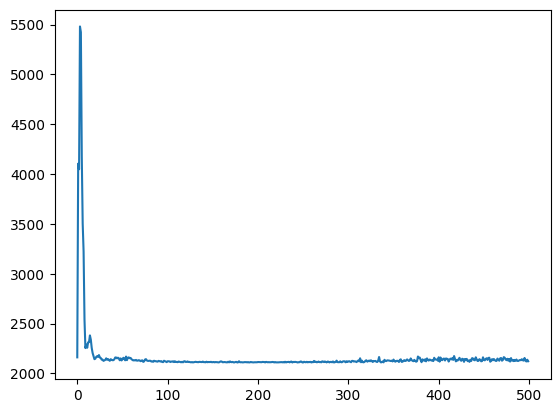

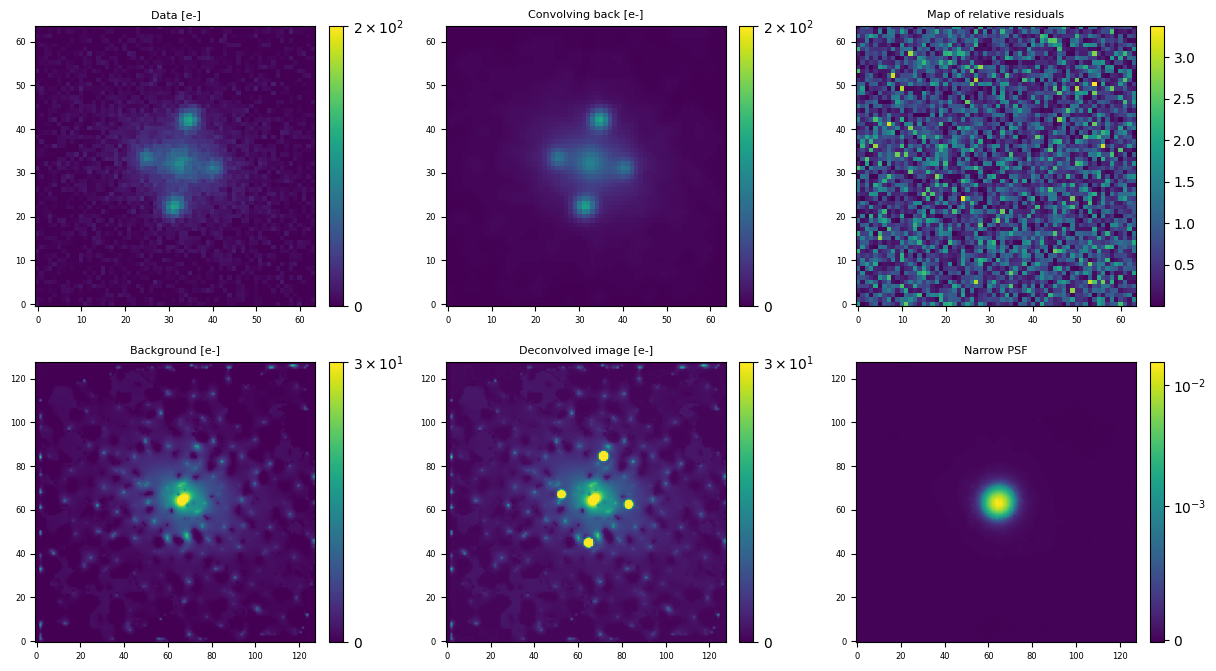

In [ ]:
cut_dict = {
            'linthresh':[200,200,None,100,100,1e-3],
            'vmin':[0,0, None, 0, 0, None],
            'vmax':[200, 200, None,30,30, None],
        }

print('Kwargs final', kwargs_final)

plt.figure()
plt.plot(optim.loss_history)
print('final loss:', optim.loss_history[-1])

fig2 = plot_deconvolution(model, data, sigma_2, s, kwargs_final, epoch = 0, units='e-', cut_dict=cut_dict)

print('Overall Reduced Chi2 : ', -2 * loss._log_likelihood_chi2(kwargs_final) / (im_size ** 2))